In [1]:
import random
import colorednoise as cn
import pandas as pd
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import yaml
import torch.nn.functional as F
from torchlibrosa.augmentation import SpecAugmentation
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from IPython.display import Audio
sys.path.append("../input/modules")
from datasets import RainForestDataset
from utils import read_hdf5
from utils import down_sampler
from utils import get_concat_down_frame
from utils import get_down_sample_matrix
from models import Cnn14_DecisionLevelAtt
from models import AttBlock
from models import ResNext50
from losses import FrameClipLoss
from datasets import FeatTrainCollater
from datasets import FeatEvalCollater
from utils import lwlrap
sys.path.append("../input/iterative-stratification-master")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
%load_ext autoreload
%autoreload 2

In [13]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
submission = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp["t_diff"] = train_tp["t_max"] - train_tp["t_min"]
train_tp["f_diff"] = train_tp["f_max"] - train_tp["f_min"]
train_fp["t_diff"] = train_fp["t_max"] - train_fp["t_min"]
train_fp["f_diff"] = train_fp["f_max"] - train_fp["f_min"]
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()
tp_list = train_tp["recording_id"].unique()
fp_list = train_fp["recording_id"].unique()

In [5]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

1     2028
2     1716
3     1635
4     1356
5      575
6      294
7      126
8       32
10      10
9        9
Name: count, dtype: int64

In [4]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

train:4727, test:1992


NameError: name 'y' is not defined

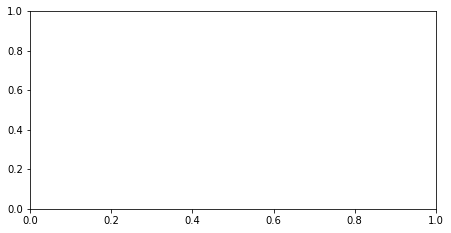

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(y)
plt.subplot(2, 2, 2)
plt.imshow(logmel.T, aspect="auto")

plt.colorbar()
y, sr = librosa.load(path=train_tp_list[10], sr=48000)
# y = (y -y.mean()) / y.std()
logmel = logmelfilterbank(
    y,
    sr,
    fft_size=2048,
    hop_size=512,
    win_length=None,
    window="hann",
    num_mels=128,
    fmin=50,
    fmax=16000,
    eps=1e-10,
)
plt.subplot(2, 2, 3)
plt.plot(y)
plt.subplot(2, 2, 4)
plt.imshow(logmel.T, aspect="auto")
plt.colorbar()

# plt.savefig("spec.png")

In [3]:
path = "dump/wave/train/551385b05.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
mel = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp = read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
matrix_fp = read_hdf5(hdf5_name=path, hdf5_path="matrix_fp")

# plt.figure(figsize=(16, 8))
# plt.subplot(2, 2, 1)
# plt.plot(wave)
# plt.subplot(2, 2, 2)
# plt.imshow(mel.T, aspect="auto")
# plt.colorbar()
# plt.subplot(2, 2, 3)
# plt.imshow(matrix_tp.T, aspect="auto")
# plt.subplot(2, 2, 4)
# plt.imshow(matrix_fp.T, aspect="auto")
# plt.colorbar()

In [ ]:
y_frame = torch.stack([torch.tensor(down_sampler(matrix_tp[3000:3512])), torch.tensor(down_sampler(matrix_tp[4500:5012]))], dim=0)
y_clip = torch.tensor((y_frame>0).any(axis=1), dtype=torch.float)
x_batch = torch.stack([torch.tensor(mel[3000:3512]), torch.tensor(mel[4500:5012])], dim=0).transpose(2,1)
print(y_frame.shape, y_clip.shape)
model = Cnn14_DecisionLevelAtt(sample_rate=16000,
        window_size=1024,
        hop_size=256,
        mel_bins=64,
        fmin=50,
        fmax=8000,
        classes_num=24,
        training=False,
        require_prep=False,
        is_spec_augmenter=False,
        mixup_lambda=None,)
model.bn0 = nn.BatchNorm2d(128)
y = model(x_batch)
bce = nn.BCEWithLogitsLoss(reduction="mean")
print(y["y_frame"].shape, y["y_clip"].shape)

In [ ]:
criterion = FrameClipLoss()
loss = criterion(y["y_frame"], y_frame, y["y_clip"], y_clip)
print(loss.item())
loss.backward(retain_graph=True)
# clip_loss = bce(y["y_clip"], y_clip)
# frame_loss = bce(y["y_frame"], y_frame)
# print(clip_loss.item())
# print(frame_loss.item())
# clip_loss.backward(retain_graph=True)
# frame_loss.backward(retain_graph=True)


In [ ]:
# sumpling function
source = y_frame[0]
new_source = torch.zeros_like(y["y_frame"][0])
l_source = 550
l_target = 16
l_effect = l_source // l_target
for i in range(l_target):
    t_start = i * l_effect
    t_end = (i+1) * l_effect
    if i == l_target -1:
        t_end = l_source
    new_source[i] = source[t_start:t_end].sum(axis=0) / l_effect
    new_source[i] = torch.tensor((source[t_start:t_end]>0).any(axis=0), dtype=torch.float)
plt.imshow(new_source.T, aspect="auto")

In [ ]:
columns = ["recording_id"] + [f"s{i}" for i in range(24)]
ground_truth = pd.DataFrame(np.zeros((len(tp_list), 25)), columns=columns)
ground_truth["recording_id"] = train_tp["recording_id"].unique()
for i, recording_id in enumerate(train_tp["recording_id"].values):
    ground_truth.iloc[ground_truth["recording_id"]==recording_id, train_tp.loc[i, "species_id"]+1] = 1.0

kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y = ground_truth.iloc[:, 1:].values
for i, (train_idx, valid_idx) in enumerate(kfold.split(y, y)):
    train_y = ground_truth.iloc[train_idx]
    valid_y = ground_truth.iloc[valid_idx]
    if i == 0:
        break
train_dataset = RainForestDataset(
    root_dir="dump/wave/train",
    train_tp=train_tp,
    train_fp=None,
    keys=["feats"],
    mode="tp",
    is_normalize=False,
    allow_cache=False,  # keep compatibility
    seed=None,
)
eval_dataset = RainForestDataset(
    files=[
        os.path.join("dump/wave/train", f"{recording_id}.h5")
        for recording_id in tp_list[valid_idx]
    ],
    keys=["feats", "matrix_tp"],
    mode="test",
    is_normalize=False,
    allow_cache=False,  # keep compatibility
    seed=None,
        )

train_collater = FeatTrainCollater(
    max_frames=512,
    l_target=16,
    mode="binary",
)
eval_collater = FeatEvalCollater(
    max_frames=512,
    n_split=3,
    is_label=True,
)
data_loader = {
"train": DataLoader(
        dataset=train_dataset,
        batch_size=64,
        collate_fn=train_collater,
        shuffle=False,
        num_workers=2,
        pin_memory=False,
    ),
"eval": DataLoader(
        eval_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=eval_collater,
        num_workers=2,
        pin_memory=False,
    ),
}
clip_list = []
for i, batch in enumerate(data_loader["train"]):
    x = batch["X"]
    y_frame = batch["y_frame"]
    y_clip = batch["y_clip"]
    clip_list.append(y_clip)
    print(x.shape)
    print(y_frame.shape)
    print(y_clip.shape)
    if i == 0:
        break

In [ ]:
x1 = []
y1_clip = []
beginnings1 = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
    beginnings1.append(batch["beginnings"])
    if i == 0:
        break
x2 = []
y2_clip = []
beginnings2 = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])
    beginnings2.append(batch["beginnings"])
    if i == 0:
        break
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

In [ ]:
x1 = []
y1_clip = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
x2 = []
y2_clip = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])


In [ ]:
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

In [ ]:
xx1.shape

In [ ]:
mode = "valid"
n_eval_split = 3
device = "cpu"
n_class = 24
l_spec = 16
keys_list = [f"X{i}" for i in range(n_eval_split)]
y_clip = [
    torch.empty((0, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_frame = [
    torch.empty((0, l_spec, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_clip_true = torch.empty((0, n_class))
model.eval()
with torch.no_grad():
    for batch in data_loader["eval"]:
        if mode == "valid":
            y_clip_true = torch.cat([y_clip_true, batch["y_clip"]], dim=0)
        x_batchs = [batch[key].to(device) for key in keys_list]
        for i in range(n_eval_split):
            y_batch_ = model(x_batchs[i])
            y_clip[i] = torch.cat([y_clip[i], y_batch_["y_clip"]], dim=0)
            y_frame[i] = torch.cat([y_frame[i], y_batch_["y_frame"]], dim=0)
# (B, n_eval_split, n_class)
y_clip = torch.stack(y_clip, dim=0).detach().cpu().numpy()
# (B, n_eval_split, T, n_class)
y_frame = torch.stack(y_frame, dim=0).detach().cpu().numpy()
if mode == "valid":
    y_clip_true = y_clip_true.numpy()
    score = lwlrap(y_clip_true, y_clip.max(axis=0))
    print(f"score:{score:.6f}")


In [ ]:
ground_truth = pd.read_csv("../input/rfcx-species-audio-detection/ground_truth.csv")
tag = "v002-cos25"
type = "wave"
with open(f"conf/tuning/Cnn14_DecisionLevelAtt.{tag}.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)
oof_path = f"exp/{type}/Cnn14_DecisionLevelAtt/{tag}/best_score/oof.h5"
y_clip = read_hdf5(oof_path, "y_clip")
y_frame = read_hdf5(oof_path, "y_frame")
print(y_clip.shape, y_frame.shape)

In [ ]:
idx = 19
recording_id = ground_truth.loc[idx, "recording_id"]
print(recording_id)
dump_path = f"dump/{type}/train/{recording_id}.h5"
idx_matrix = read_hdf5(dump_path, "matrix_tp")
l_original = len(idx_matrix)
ground_truth_frame = get_down_sample_matrix(idx_matrix, l_target=config["l_target"], max_frames=config["max_frames"], n_eval_split=config["n_eval_split"], mode="binary")
concat_y_frame = get_concat_down_frame(y_frame[idx], l_original=l_original, max_frames=config["max_frames"])
concat_ground_truth = get_concat_down_frame(ground_truth_frame, l_original=l_original, max_frames=config["max_frames"])

true_clip = idx_matrix.any(axis=0).astype(np.int64)[:24].reshape(1, -1)
pred_clip = y_clip[idx].max(axis=0)[:24].reshape(1, -1)
pred_frame_clip = concat_y_frame.max(axis=0)[:24].reshape(1, -1)
score1 = lwlrap(true_clip, pred_clip)
score2 = lwlrap(true_clip, pred_frame_clip)
score3 = lwlrap(true_clip, pred_clip+pred_frame_clip)

print(f"clip:{score1:.5f}, frame: {score2:.5f}, ensemble: {score3:.5f}")

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1)
plt.title(f"clip:{score1:.5f}, frame: {score2:.5f}, ensemble: {score3:.5f}")
plt.imshow(idx_matrix.T, aspect="auto")
plt.subplot(4, 1, 2)
plt.title("Clip")
plt.imshow(y_clip[idx].T, aspect="auto")
plt.subplot(4, 1, 3)
plt.title("Frame")
plt.imshow(concat_y_frame.T, aspect="auto")
plt.subplot(4, 1, 4)
plt.title("Frame-true")
plt.imshow(concat_ground_truth.T, aspect="auto")
plt.tight_layout()

In [ ]:
# for center loss
a = torch.where(torch.tensor([[0,1,0],[1,1,0]])==1)
a

In [ ]:
plt.plot(pred_frame_clip.flatten(), alpha=0.5)
plt.plot(true_clip.flatten(), alpha=0.5)

In [ ]:
plt.plot(concat_y_frame[:,24])

In [ ]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
x1 = torch.stack([x,x,x]).transpose(1,0)
conv1 = nn.Conv2d(1, 3, 1, 1)
conv_out = conv1(x.unsqueeze(1))
conv_out.shape

In [ ]:
for name,_ in model.named_parameters():
    print(name)

In [ ]:
x = resnext50_32x4d.conv1(x1)
print(x.shape)
x = resnext50_32x4d.bn1(x)
print(x.shape)
x = resnext50_32x4d.relu(x)
print(x.shape)
x = resnext50_32x4d.maxpool(x)
print(x.shape)
x = resnext50_32x4d.layer1(x)
print(x.shape)
x = resnext50_32x4d.layer2(x)
print(x.shape)
x = resnext50_32x4d.layer3(x)
print(x.shape)
x = resnext50_32x4d.layer4(x)
print(x.shape)
x = resnext50_32x4d.avgpool(x)
print(x.shape)
x = torch.flatten(x, 1)
print(x.shape)
y1 = resnext50_32x4d.fc(x)
print(y1.shape)

In [ ]:
model = ResNext50(num_mels=128,
        classes_num=25,
        training=False,
        is_spec_augmenter=True)
yy = model(x)

In [ ]:
print(yy["y_frame"].shape, yy["y_clip"].shape, yy["embedding"].shape)

In [7]:
class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray):
        if self.always_apply:
            return self.apply(y)
        else:
            if np.random.rand() < self.p:
                return self.apply(y)
            else:
                return y

    def apply(self, y: np.ndarray):
        raise NotImplementedError


class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y


class OneOf:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        n_trns = len(self.transforms)
        trns_idx = np.random.choice(n_trns)
        trns = self.transforms[trns_idx]
        return trns(y)
    
class TimeStretch(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_rate=1.2):
        super().__init__(always_apply, p)

        self.max_rate = max_rate

    def apply(self, y: np.ndarray, **params):
        rate = np.random.uniform(0, self.max_rate)
        rate = 0.9
        augmented = librosa.effects.time_stretch(y, rate)
        return augmented

In [25]:
from IPython.display import Audio
sr = 48000
path = "dump/wave_sp0.9/train/00ad36516.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="matrix_fp")
# transform = TimeStretch(always_apply=True, max_rate=1.1)
# rate = 0.9
# augmented = librosa.effects.time_stretch(wave, rate)
# y_time_stretch = transform(wave)
print(wave.shape)
# print(augmented.shape)
# Audio(y_time_stretch, rate=sr)

(6251, 25)


In [9]:
print(wave.shape, y_time_stretch.shape)

(2880000,) (3200000,)


In [12]:
Audio(wave, rate=sr)

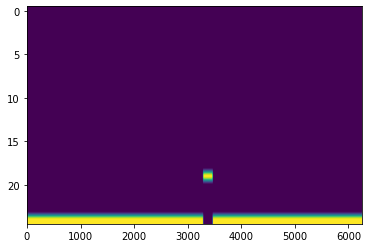

In [26]:
plt.imshow(wave.T, aspect="auto")

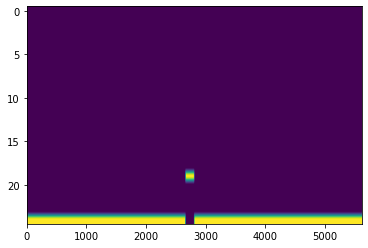

In [21]:
plt.imshow(wave.T, aspect="auto")

In [27]:
3300/6251

0.5279155335146376

In [24]:
wave.shape

(5626, 25)